In [6]:
#核心代码来自微信号gh_30599cd767ee，野生交易员的试炼之路。
#3.0版本：常用功能都封装成了函数，加入滑点、手续费。
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline #魔法命令，用于在jupyter 环境中正常显示图表
plt.rcParams['font.sans-serif']=['SimHei'] #用来在图中正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来在图中正常显示负号

datename = '180101To220825'
pricefilename = '{}{}{}'.format('data/price_',datename,'.pkl')
premfilename = '{}{}{}'.format('data/prem_',datename,'.pkl')
sizefilename = '{}{}{}'.format('data/size_',datename,'.pkl')
day_returnfilename = '{}{}{}'.format('data/day_return_',datename,'.pkl')
price100filename = '{}{}{}'.format('data/price100_',datename,'.pkl')
prem100filename = '{}{}{}'.format('data/prem100_',datename,'.pkl')
size100filename = '{}{}{}'.format('data/size100_',datename,'.pkl')
priceRankfilename = '{}{}{}'.format('data/priceRank_',datename,'.pkl')
premRankfilename = '{}{}{}'.format('data/premRank_',datename,'.pkl')
sizeRankfilename = '{}{}{}'.format('data/sizeRank_',datename,'.pkl')

pricedf=pd.read_pickle(pricefilename)  #读取收盘价矩阵
premdf=pd.read_pickle(premfilename)    #读取溢价率矩阵。
sizedf=pd.read_pickle(sizefilename)    #读取余额矩阵。
day_return=pd.read_pickle(day_returnfilename)  #读取收益率矩阵
price100df=pd.read_pickle(price100filename)  #读取收盘价百分数矩阵
prem100df=pd.read_pickle(prem100filename)    #读取溢价率百分数矩阵。
size100df=pd.read_pickle(size100filename)    #读取余额百分数矩阵。
priceRankdf=pd.read_pickle(priceRankfilename)  #读取收盘价排名矩阵
premRankdf=pd.read_pickle(premRankfilename)    #读取溢价率排名矩阵。
sizeRankdf=pd.read_pickle(sizeRankfilename)    #读取余额排名矩阵。

In [7]:
# 取排名最小的N个标的，用bool值表示
def filtTopN(factor: pd.DataFrame,N=10)->pd.DataFrame:    
    return factor.apply(lambda x:x.rank(method='first')<=N,axis=1)  #升序排列，从小到大

# 取排名最大的N个标的，用bool值表示
def filtTopN100(factor: pd.DataFrame,N=10)->pd.DataFrame:    
    return factor.apply(lambda x:x.rank(ascending=False,method='first')<=N,axis=1)  #降序排列，即从大到小

# 计算每日盈亏，输入信号、日收益表、调仓频率、 单向换仓成本
def calc_pnl(signal:pd.DataFrame,day_return:pd.DataFrame,freq=1, cost_k=0.0001) ->pd.Series:   
    signal_freq=pd.DataFrame(index=signal.index)
    signal_freq=signal_freq.join(signal.iloc[range(0,len(signal),freq)])
    signal_freq=signal_freq.fillna(method='pad')
    gross_pnl=day_return[signal_freq].sum(axis=1)/signal_freq.sum(axis=1)
    cost=abs(signal_freq.diff()).sum(axis=1)*cost_k/signal_freq.sum(axis=1)
    return gross_pnl-cost

#常见的评估指标包括：总收益率、年化收益率、最大回撤率、夏普率、卡玛率。
maxdd = lambda pnl: (1-(1+pnl).cumprod()/(1+pnl).cumprod().expanding().max()).max()
sharpe=lambda pnl:(pnl.mean() / pnl.std()) * (243**0.5)
gain_total=lambda pnl:(1+pnl).prod()-1
gain_yearly=lambda pnl:(1+pnl).prod()**(243/len(pnl))-1
calmar=lambda pnl:gain_yearly(pnl)/maxdd(pnl)

<AxesSubplot:xlabel='tradeDate'>

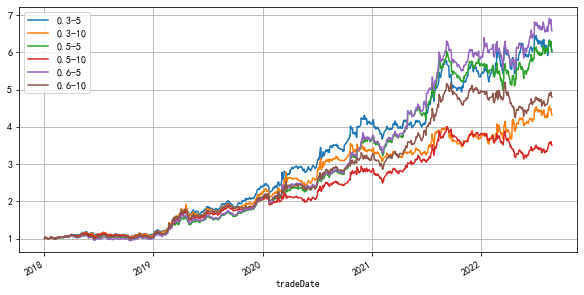

In [21]:
res=pd.DataFrame()
N = 5
l=[]
for k in [0.3,0.5,0.6]:
    for freq in [5,10]:
        factor=k*premdf+(k*3/7)*pricedf+(1-k-k*3/7)*sizedf
        signal=filtTopN(factor,N)
        a=str(k)+"-"+str(freq)
        pnl = calc_pnl(signal,day_return,freq,0.001)
        res[a]=pnl
        d={ '因子':"k="+str(k),'总收益':gain_total(pnl),'年化收益':gain_yearly(pnl),'最大回撤':maxdd(pnl),
            '夏普率':sharpe(pnl),'卡玛率':calmar(pnl),'2022收益':gain_total(pnl['2022']),'2022最大回撤':maxdd(pnl['2022']),}
        l.append(d)
(1+res).cumprod().plot(figsize=(10,5),grid=True)

In [22]:
result=pd.DataFrame(l)
result

,因子,总收益,年化收益,最大回撤,夏普率,卡玛率,2022收益,2022最大回撤
0,k=0.3,5.044394,0.472399,0.147748,1.868126,3.197332,0.116857,0.124568
1,k=0.3,3.316126,0.369536,0.171895,1.455616,2.149772,0.152645,0.116852
2,k=0.5,5.015700,0.470893,0.175000,1.913026,2.690822,0.055251,0.128370
3,k=0.5,2.503103,0.309427,0.216744,1.380036,1.427618,-0.084546,0.194084
4,k=0.6,5.574784,0.499273,0.145160,1.975906,3.439468,0.116274,0.135061
5,k=0.6,3.800846,0.401243,0.184017,1.625370,2.180464,-0.034013,0.184017


<AxesSubplot:xlabel='tradeDate'>

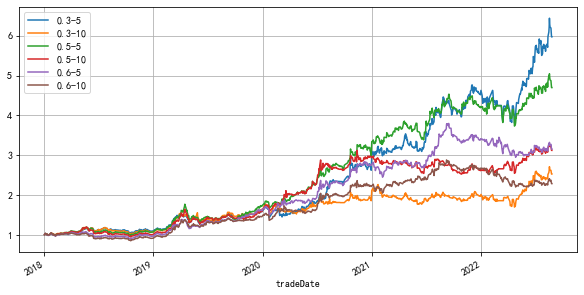

In [19]:
res=pd.DataFrame()
N = 5
l=[]
for k in [0.3,0.5,0.6]:
    for freq in [5,10]:
        factor=k*premRankdf+(k*3/7)*priceRankdf+(1-k-k*3/7)*sizeRankdf
        signal=filtTopN(factor,N)
        a=str(k)+"-"+str(freq)
        pnl = calc_pnl(signal,day_return,freq,0.001)
        res[a]=pnl
        d={ '因子':"k="+str(k),'总收益':gain_total(pnl),'年化收益':gain_yearly(pnl),'最大回撤':maxdd(pnl),
            '夏普率':sharpe(pnl),'卡玛率':calmar(pnl),'2022收益':gain_total(pnl['2022']),'2022最大回撤':maxdd(pnl['2022']),}
        l.append(d)
(1+res).cumprod().plot(figsize=(10,5),grid=True)

In [20]:
result=pd.DataFrame(l)
result   #标准化的结果表明：复杂的统计还不如简单的计算！

,因子,总收益,年化收益,最大回撤,夏普率,卡玛率,2022收益,2022最大回撤
0,k=0.3,4.973739,0.468680,0.201903,1.603719,2.321309,0.290424,0.178280
1,k=0.3,1.527209,0.220635,0.250125,0.960903,0.882099,0.253587,0.155699
2,k=0.5,3.698883,0.394789,0.259405,1.590513,1.521903,0.111623,0.160431
3,k=0.5,2.121882,0.277384,0.226512,1.244346,1.224589,0.185323,0.105966
4,k=0.6,2.151929,0.280018,0.223946,1.347090,1.250379,-0.076185,0.145705
5,k=0.6,1.286329,0.194623,0.235899,1.001910,0.825025,-0.145431,0.176818


<AxesSubplot:xlabel='tradeDate'>

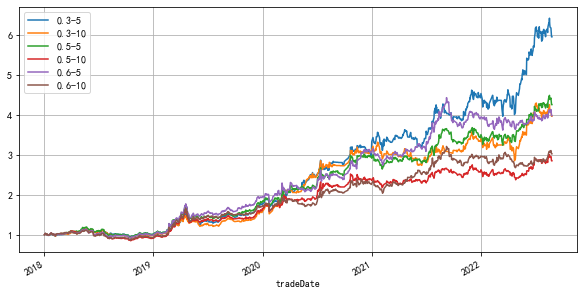

In [17]:
res=pd.DataFrame()
N = 5
l=[]
for k in [0.3,0.5,0.6]:
    for freq in [5,10]:
        factor=k*prem100df+(k*3/7)*price100df+(1-k-k*3/7)*size100df
        signal=filtTopN100(factor,N)
        a=str(k)+"-"+str(freq)
        pnl = calc_pnl(signal,day_return,freq,0.001)
        res[a]=pnl
        d={ '因子':"k="+str(k),'总收益':gain_total(pnl),'年化收益':gain_yearly(pnl),'最大回撤':maxdd(pnl),
            '夏普率':sharpe(pnl),'卡玛率':calmar(pnl),'2022收益':gain_total(pnl['2022']),'2022最大回撤':maxdd(pnl['2022']),}
        l.append(d)
(1+res).cumprod().plot(figsize=(10,5),grid=True)

In [18]:
result=pd.DataFrame(l)
result   #标准化的结果表明：复杂的统计还不如简单的计算！

,因子,总收益,年化收益,最大回撤,夏普率,卡玛率,2022收益,2022最大回撤
0,k=0.3,4.951230,0.467489,0.190259,1.731651,2.457122,0.312290,0.133944
1,k=0.3,2.966502,0.344882,0.201602,1.409385,1.710705,0.161377,0.176003
2,k=0.5,3.257171,0.365491,0.213804,1.497828,1.709466,0.213592,0.094413
3,k=0.5,1.851867,0.252775,0.248512,1.147781,1.017152,0.084725,0.104388
4,k=0.6,2.981464,0.345971,0.198449,1.430351,1.743374,0.007679,0.084246
5,k=0.6,2.025713,0.268818,0.221026,1.193440,1.216224,0.018112,0.125670
